In [1]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

## Loading Dataset

In [2]:
data = pd.read_csv('AAPL15_20.csv')
data = data.set_index('Date')
data.index = pd.DatetimeIndex(data.index)
data = data.drop(['Volume', 'Adj Close'], axis=1)
print("Data size", len(data))
data_next = data.copy()
data.head()

Data size 1490


,Open,High,Low,Close
Date,,,,
2015-02-02,29.512501,29.792500,29.020000,29.657499
2015-02-03,29.625000,29.772499,29.402500,29.662500
2015-02-04,29.625000,30.127501,29.577499,29.889999
2015-02-05,30.004999,30.057501,29.812500,29.985001
2015-02-06,30.004999,30.062500,29.612499,29.732500


<AxesSubplot:xlabel='Date'>

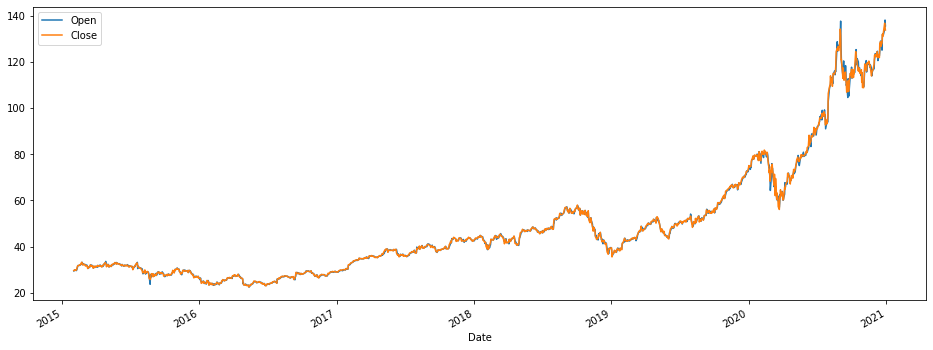

In [81]:
data[['Open', 'Close']].plot(figsize=(16,6))

## Adding indicators
#### Simple moving average (5 days and 20 days), Typical price, mean price, Exponential moving average (5 days)

In [82]:
data['SMA5'] = data['Close'].rolling(window=5).mean()
data['SMA20'] = data['Close'].rolling(window=20).mean()
data['TP'] = (data['High'] + data['Low'] +data['Close'])/3 #typical price
data['MP'] = (data['High'] + data['Low'])/2 #mean price
data['EMA5'] = data['Close'].ewm(span=5, adjust=False).mean() #Exponential moving average
data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()

#### Bollinger Bands and Super trend

In [83]:
import pandas_ta as ta

data['std'] = data['TP'].rolling(20).std(ddof=0)
data['MA-TP'] = data['TP'].rolling(20).mean()
data['BOLU'] = data['MA-TP'] + 2*data['std']
data['BOLD'] = data['MA-TP'] - 2*data['std']
data = data.drop(['std', 'MA-TP'], axis=1)

sti = ta.supertrend(data['High'], data['Low'], data['Close'], 10, 3) #length, multiplier
data["Super Trend"] = sti["SUPERT_10_3.0"]

In [84]:
data = data.apply(np.log) #converting prices to log scale

data["Y"] = data['Close'].shift(-1)
data = data.dropna()

#### Visualizing all indicators

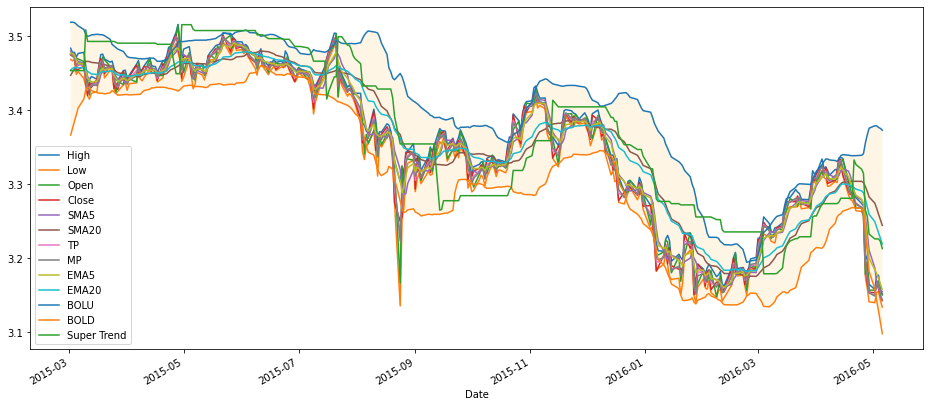

In [85]:
data_slice = data[:300].copy()
ax = data_slice[['High', 'Low', 'Open', 'Close', 'SMA5', 'SMA20', 'TP', 'MP', 'EMA5',
       'EMA20', 'BOLU', 'BOLD', 'Super Trend']].plot(figsize=(16,7))
ax.fill_between(data_slice.index, data_slice['BOLD'], data_slice['BOLU'], facecolor='orange', alpha=0.1)
plt.show()

In [86]:
#first few rows of data
data.head()

,Open,High,Low,Close,SMA5,SMA20,TP,MP,EMA5,EMA20,BOLU,BOLD,Super Trend,Y
Date,,,,,,,,,,,,,,
2015-03-02,3.475454,3.483392,3.468077,3.474215,3.479593,3.446927,3.475248,3.475764,3.476595,3.454001,3.518464,3.366236,3.453208,3.476305
2015-03-03,3.473208,3.477541,3.466439,3.476305,3.475253,3.451189,3.473441,3.472005,3.476498,3.456147,3.518661,3.375482,3.453208,3.469946
2015-03-04,3.474293,3.477850,3.468233,3.469946,3.474866,3.455101,3.472018,3.473053,3.474319,3.457469,3.517932,3.385131,3.453208,3.453236
2015-03-05,3.470257,3.471578,3.448081,3.453236,3.468638,3.457802,3.457683,3.459899,3.467341,3.457067,3.515957,3.393710,3.453208,3.454738
2015-03-06,3.468856,3.476382,3.452049,3.454738,3.465736,3.460421,3.461116,3.464290,3.463157,3.456845,3.513535,3.402786,3.453208,3.458994


# Naive Forecast

In [3]:
data = data_next.copy()

m = len(data)
test_size = math.ceil(m*0.3)
train_data = data[: -test_size].copy()
test_data = data[-test_size: ].copy()

print("Train data length:", len(train_data))
print("Test data length:", len(test_data))

Train data length: 1043
Test data length: 447


In [7]:
test_data['NaivePrediction'] = test_data['Close'].shift(1)
y_test = test_data.iloc[20: ]["Close"]
y_pred = test_data.iloc[20: ]["NaivePrediction"]

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("R2: ", r2)
print("MAPE: ", mape)

MSE:  4.304262453133555
RMSE:  2.0746716494745754
MAE:  1.3613933255269326
R2:  0.9936668739702175
MAPE:  0.01686361171905916


## ANN using Dense layers

###### Spliting dataset into inputs and outputs

In [87]:
X = data[['High', 'Low', 'Open', 'Close', 'SMA5', 'SMA20', 'TP', 'MP', 'EMA5', 'EMA20', 'BOLU', 'BOLD', 'Super Trend']].to_numpy()
Y = data["Y"].to_numpy()

In [10]:
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler(feature_range=(0, 1))
#X_scaled = scaler.fit_transform(X)
#Y_scaled = scaler.fit_transform(Y.reshape(-1, 1))

###### Train test split (70/30)

In [88]:
m = len(data)
test_size = math.ceil(m*0.3)
X_train, y_train = X[: -test_size], Y[: -test_size]
X_test, y_test = X[-test_size: ], Y[-test_size: ]

print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Train data shape: (1029, 13)
Test data shape: (441, 13)


###### Feature selection

#### Selecting best model using random search

In [89]:
from tensorflow import keras
from keras_tuner import RandomSearch
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten

In [217]:
def build_model(hp):           
    model=Sequential()
    model.add(Input(shape=(X_train.shape[1], )))
    for i in range(hp.Int('num_of_layers',1, 3)):         
        model.add(Dense(units=hp.Int('num_of_neurons'+ str(i), min_value=16, max_value=64, step=2),
                                    activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam',  loss='mse')
    return model

In [219]:
tuner=RandomSearch(build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='best_model/',
    project_name='all_fea')
tuner.search(X_train, y_train, epochs=500, validation_data=(X_test, y_test))

Trial 5 Complete [00h 06m 12s]
val_loss: 0.0006124255014583468

Best val_loss So Far: 0.0005937134847044945
Total elapsed time: 00h 31m 43s
INFO:tensorflow:Oracle triggered exit


#### Selected model architecture 

In [220]:
selectd_model = tuner.get_best_models()[0]
selectd_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                420       
                                                                 
 dense_1 (Dense)             (None, 58)                1798      
                                                                 
 dense_2 (Dense)             (None, 1)                 59        
                                                                 
Total params: 2,277
Trainable params: 2,277
Non-trainable params: 0
_________________________________________________________________


#### Training model

In [221]:
epochs = 4000
best_score = 0.0
best_epochs = 0
for i in range(int(epochs/10)):
    selectd_model.fit(X_train, y_train, epochs=10, batch_size = 32, verbose=False)
    y_pred = selectd_model.predict(X_test)
    score = r2_score(y_test, y_pred)
    if score > best_score:
        best_score = score
        selectd_model.save('model_dense_final.h5')
        best_epochs = i*10
    print("Epochs:", i*10, end="  ")
    print("score:", score, end="  ")
    print("best_score:", best_score)

print(best_score, best_epochs)

Epochs: 0  score: 0.9944808548883036  best_score: 0.9944808548883036
Epochs: 10  score: 0.993145037953807  best_score: 0.9944808548883036
Epochs: 20  score: 0.9904417467263302  best_score: 0.9944808548883036
Epochs: 30  score: 0.9929501144095486  best_score: 0.9944808548883036
Epochs: 40  score: 0.9839636791797801  best_score: 0.9944808548883036
Epochs: 50  score: 0.9890404178338494  best_score: 0.9944808548883036
Epochs: 60  score: 0.990973770165096  best_score: 0.9944808548883036
Epochs: 70  score: 0.994340751124622  best_score: 0.9944808548883036
Epochs: 80  score: 0.9944714145172547  best_score: 0.9944808548883036
Epochs: 90  score: 0.9943908959045646  best_score: 0.9944808548883036
Epochs: 100  score: 0.9945184788834732  best_score: 0.9945184788834732
Epochs: 110  score: 0.9904103637919597  best_score: 0.9945184788834732
Epochs: 120  score: 0.9942497070680889  best_score: 0.9945184788834732
Epochs: 130  score: 0.9943082440294719  best_score: 0.9945184788834732
Epochs: 140  score: 

In [90]:
model_dense = load_model('model_dense_final.h5')

#### Evaluating model performance

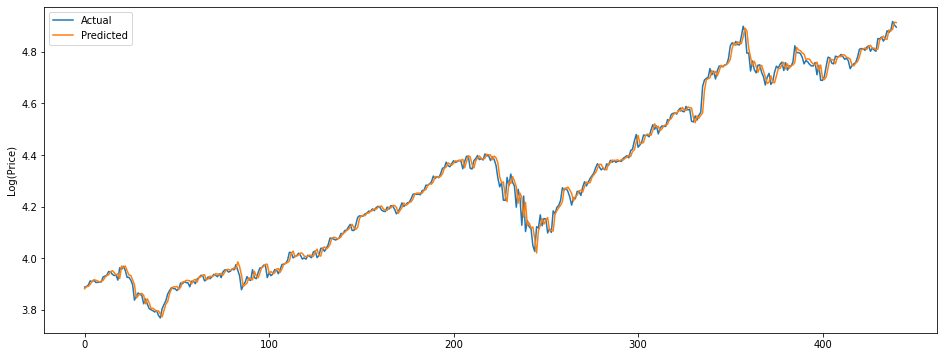

In [91]:
plt.figure(figsize=(16, 6))
y_pred = model_dense.predict(X_test)
plt.plot(y_test, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.ylabel('Log(Price)')
plt.legend()

In [92]:
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("R2: ", r2)
print("MAPE: ", mape)

MSE:  0.0005634452524580675
RMSE:  0.023737001757974142
MAE:  0.01609010301697603
R2:  0.9946897936594632
MAPE:  0.0037309856277994067


#### Predicting custom input

In [93]:
import pandas_ta as ta
def predict(data, model):
  data['SMA5'] = data['Close'].rolling(window=5).mean()
  close = data['Close'].to_numpy()
  data['SMA20'] = data['Close'].rolling(window=20).mean()
  data['TP'] = (data['High'] + data['Low'] +data['Close'])/3 #typical price
  data['MP'] = (data['High'] + data['Low'])/2 #mean price
  data['EMA5'] = data['Close'].ewm(span=5, adjust=False).mean() #Exponential moving average
  data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()

  data['std'] = data['TP'].rolling(20).std(ddof=0)
  data['MA-TP'] = data['TP'].rolling(20).mean()
  data['BOLU'] = data['MA-TP'] + 2*data['std']
  data['BOLD'] = data['MA-TP'] - 2*data['std']
  data = data.drop(['std', 'MA-TP'], axis=1)

  sti = ta.supertrend(data['High'], data['Low'], data['Close'], 10, 3)
  data["Super Trend"] = sti["SUPERT_10_3.0"]
  data = data.apply(np.log) #converting prices to log scale
  X_data = data[-1:].to_numpy()
  pred = model.predict(X_data)[0]
  return np.exp(pred), close

In [94]:
# Provide Open, High, Low and Close data of previous 20 days
data = data_next[-20:].copy()
pred, prev = predict(data, model_dense)
print("previous price:", data["Close"][-1])
print("Predicted Price:", np.squeeze(pred))

previous price: 133.720001
Predicted Price: 135.395


## LSTM model (on historical log returns)

#### Loading and processing dataset

In [18]:
data = data_next.copy()
data["LogClose"] = np.log(data["Close"])
data["Return"] = data["LogClose"].diff()
data['ShiftLogClose'] = data['LogClose'].shift(1)

m = len(data)
test_size = math.ceil(m*0.3)

train_data = data.iloc[: -test_size]
test_data = data.iloc[-test_size: ]

In [19]:
train_ret = train_data['Return'].dropna().to_numpy()
test_ret = test_data['Return'].dropna().to_numpy()

#### Creating training and testing data

In [20]:
Tx = 5
def generate_data(data, Tx):
  X, Y = [], []
  for t in range(len(data)-Tx):
      X.append(data[t: t+Tx])
      Y.append(data[t+Tx])
  X = np.array(X).reshape(-1, Tx, 1)
  Y = np.array(Y)
  return X, Y

X_train, y_train = generate_data(train_ret, Tx)
X_test, y_test = generate_data(test_ret, Tx)

#### Defining model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

model = Sequential()
model.add(LSTM(units=100, return_sequences = True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=70, return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(units=50, return_sequences = False))
model.add(Dense(units =30))
model.add(Dense(units =1))
model.compile(optimizer='adam',loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 100)            40800     
_________________________________________________________________
dropout (Dropout)            (None, 5, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 70)             47880     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 70)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                24200     
_________________________________________________________________
dense (Dense)                (None, 30)                1530      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

In [22]:
def evaluate(model):
  prev = test_data[Tx:]['ShiftLogClose'].to_numpy()
  pred_ret = model.predict(X_test)
  y_pred = prev + np.squeeze(pred_ret)
  y_test = test_data[Tx:]['LogClose'].to_numpy()
  return r2_score(y_test, y_pred)

#### Training

In [141]:
epochs = 300
best_score = 0.0
best_epochs = 0
for i in range(epochs):
    model.fit(X_train, y_train, epochs=1, batch_size = 32, verbose=False)
    score = evaluate(model)
    if score > best_score:
        best_score = score
        model.save('model_lstm_final.h5')
        best_epochs = i
    print("Epoch:", i, end = '  ')
    print("score:", score, end= '  ')
    print("Best_score:", best_score)
print(best_score, best_epochs)

Epoch: 0  score: 0.9944331257934401  Best_score: 0.9944331257934401
Epoch: 1  score: 0.9944239263042348  Best_score: 0.9944331257934401
Epoch: 2  score: 0.9943239850211207  Best_score: 0.9944331257934401
Epoch: 3  score: 0.9941878048942013  Best_score: 0.9944331257934401
Epoch: 4  score: 0.9944175856357333  Best_score: 0.9944331257934401
Epoch: 5  score: 0.9941599672680912  Best_score: 0.9944331257934401
Epoch: 6  score: 0.9944499848874234  Best_score: 0.9944499848874234
Epoch: 7  score: 0.9944504857268964  Best_score: 0.9944504857268964
Epoch: 8  score: 0.9944191090580247  Best_score: 0.9944504857268964
Epoch: 9  score: 0.994450970428815  Best_score: 0.994450970428815
Epoch: 10  score: 0.994296573031616  Best_score: 0.994450970428815
Epoch: 11  score: 0.9943780721089083  Best_score: 0.994450970428815
Epoch: 12  score: 0.994448801274954  Best_score: 0.994450970428815
Epoch: 13  score: 0.9943694106323543  Best_score: 0.994450970428815
Epoch: 14  score: 0.9944435528851782  Best_score: 0.

#### Prediction

In [23]:
model_lstm = load_model('model_lstm_final.h5')

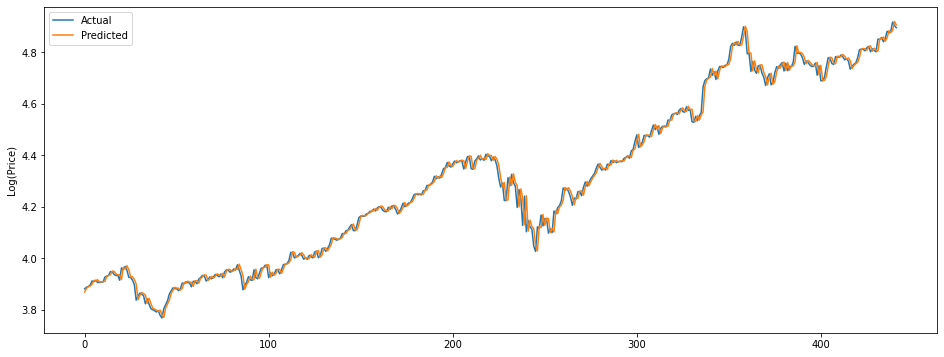

In [24]:
prev = test_data[Tx:]['ShiftLogClose'].to_numpy()
pred_ret = model_lstm.predict(X_test)
y_pred = prev + np.squeeze(pred_ret)
y_test = test_data[Tx:]['LogClose'].to_numpy()

plt.figure(figsize=(16, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.ylabel("Log(Price)")
plt.legend()

In [25]:
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("R2: ", r2)
print("MAPE: ", mape)

MSE:  0.0005895888999885423
RMSE:  0.02428145176855252
MAE:  0.016459405807058784
R2:  0.9944518625480494
MAPE:  0.0038196187096450774


#### Predicting custom input

In [75]:
#provide previous 6 days closing data
def prediction(data, model):
    
    data["LogClose"] = np.log(data["Close"])
    data["Return"] = data["LogClose"].diff()
    X_data = data['Return'].dropna().to_numpy()
    X_data = X_data.reshape(1, -1, 1)

    prev =data["LogClose"][-1]
    pred_ret = model.predict(X_data)
    y_pred = prev + np.squeeze(pred_ret)
    return y_pred
    
    
data = data_next[-6:].copy()   
y_pred = prediction(data, model_lstm)
print("Previous prices:", data["Close"][1:].to_numpy())
print('Prediction', np.exp(y_pred))

Previous prices: [130.960007 131.970001 136.690002 134.869995 133.720001]
Prediction 134.02464254492696
